In [29]:
import numpy as np
import pandas as pd
from sklearn import datasets
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt


In [5]:
print("GPU Available:", tf.test.is_gpu_available())

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


GPU Available: False


In [6]:
# Check TPU availability
tpu_available = False
devices = tf.config.list_logical_devices()
for device in devices:
    if device.device_type == 'TPU':
        tpu_available = True
        break

print("TPU Available:", tpu_available)

TPU Available: False


In [7]:
"""
Leer los datos y asignar columnas
"""
def read_data():
  file_name = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data"
  df = pd.read_csv(f"{file_name}", sep=",", header=None, engine='python')
  COL_NAMES = ["wine_class", "alcohol", "malic_acid", "ash", "alcalinity_of_ash", "magnesium", "total_phenols", "flavanoids", "nonflavanoid_phenols", "proanthocyanins", "color_intensity", "hue", "od280_od315_of_diluted_wines", "proline"]
  df.columns = COL_NAMES
  return df


In [8]:
wine_df = read_data()

X = wine_df.iloc[: , 1:]
y = wine_df.iloc[: ,0].values

In [9]:
COL_NAMES = ["alcohol", "malic_acid", "ash", "alcalinity_of_ash", "magnesium", "total_phenols", "flavanoids", "nonflavanoid_phenols", "proanthocyanins", "color_intensity", "hue", "od280_od315_of_diluted_wines", "proline"]

In [10]:
wine_df.head(15)

,wine_class,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280_od315_of_diluted_wines,proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735
5,1,14.20,1.76,2.45,15.2,112,3.27,3.39,0.34,1.97,6.75,1.05,2.85,1450
6,1,14.39,1.87,2.45,14.6,96,2.50,2.52,0.30,1.98,5.25,1.02,3.58,1290
7,1,14.06,2.15,2.61,17.6,121,2.60,2.51,0.31,1.25,5.05,1.06,3.58,1295
8,1,14.83,1.64,2.17,14.0,97,2.80,2.98,0.29,1.98,5.20,1.08,2.85,1045
9,1,13.86,1.35,2.27,16.0,98,2.98,3.15,0.22,1.85,7.22,1.01,3.55,1045


In [11]:
X.values[0]

array([1.423e+01, 1.710e+00, 2.430e+00, 1.560e+01, 1.270e+02, 2.800e+00,
       3.060e+00, 2.800e-01, 2.290e+00, 5.640e+00, 1.040e+00, 3.920e+00,
       1.065e+03])

In [12]:
# One hot encode labels
one_hot_encoder = OneHotEncoder(sparse=False)
one_hot_labels = one_hot_encoder.fit_transform(np.array(y).reshape(-1, 1))


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [20]:
# Constantes
NOISE_DIM = 100
NUM_CLASSES = 3
NUM_FEATURES = 13
BATCH_SIZE = 32
TRAINING_STEPS = 3000

In [14]:
# Generator
def create_generator():
    noise_input = Input(shape=(NOISE_DIM,))
    class_input = Input(shape=(NUM_CLASSES,))
    merged_input = Concatenate()([noise_input, class_input])
    hidden = Dense(128, activation='relu')(merged_input)
    output = Dense(NUM_FEATURES, activation='linear')(hidden)
    model = Model(inputs=[noise_input, class_input], outputs=output)
    return model

# Discriminator
def create_discriminator():
    data_input = Input(shape=(NUM_FEATURES,))
    class_input = Input(shape=(NUM_CLASSES,))
    merged_input = Concatenate()([data_input, class_input])
    hidden = Dense(128, activation='relu')(merged_input)
    output = Dense(1, activation='sigmoid')(hidden)
    model = Model(inputs=[data_input, class_input], outputs=output)
    return model

In [15]:
# cGAN
def create_cgan(generator, discriminator):
    noise_input = Input(shape=(NOISE_DIM,))
    class_input = Input(shape=(NUM_CLASSES,))
    generated_data = generator([noise_input, class_input])
    validity = discriminator([generated_data, class_input])
    model = Model(inputs=[noise_input, class_input], outputs=validity)
    return model

In [16]:
# Crear y compilar the Discriminator
discriminator = create_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer=Adam())

# Crear el Generator
generator = create_generator()

# Crear GAN
gan = create_cgan(generator, discriminator)

# Validar de que solo el generador esté entrenado
discriminator.trainable = False

gan.compile(loss='binary_crossentropy', optimizer=Adam())


In [21]:
# Entrenar GAN
for step in range(TRAINING_STEPS):
    # Seleccione un lote aleatorio de datos reales con etiquetas
    idx = np.random.randint(0, X.shape[0], BATCH_SIZE)
    real_batch = X.iloc[idx].values
    labels_batch = one_hot_labels[idx]

    # Generar un lote de nuevos datos
    noise = np.random.normal(0, 1, (BATCH_SIZE, NOISE_DIM))
    generated_batch = generator.predict([noise, labels_batch])

    # Entrenar discriminator
    real_loss = discriminator.train_on_batch([real_batch, labels_batch], np.ones((BATCH_SIZE, 1)))
    fake_loss = discriminator.train_on_batch([generated_batch, labels_batch], np.zeros((BATCH_SIZE, 1)))
    discriminator_loss = 0.5 * np.add(real_loss, fake_loss)

    # Entrenar generator
    generator_loss = gan.train_on_batch([noise, labels_batch], np.ones((BATCH_SIZE, 1)))

    if step % 500 == 0:
        print(f"Step: {step}, Discriminator Loss: {discriminator_loss}, Generator Loss: {generator_loss}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Step: 0, Discriminator Loss: 0.7511512041091919, Generator Loss: [array(0.7556657, dtype=float32), array(0.7556657, dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms

In [22]:
gan.save("cgan.h5")
gan.save('cgan.keras')

In [23]:
import keras
keras.saving.save_model(gan, 'cgan_model.keras')

In [24]:
# Generate instances for a given class
def generate_data(generator, data_class, num_instances):
    one_hot_class = one_hot_encoder.transform(np.array([[data_class]]))
    noise = np.random.normal(0, 1, (num_instances, NOISE_DIM))
    generated_data = generator.predict([noise, np.repeat(one_hot_class, num_instances, axis=0)])
    return pd.DataFrame(generated_data, columns=COL_NAMES)



In [25]:
# Generate 40 instances of class 1
generated_data = generate_data(generator, 1, 10)
print(generated_data)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
     alcohol  malic_acid        ash  alcalinity_of_ash  magnesium  \
0 -11.476312  -10.161321  12.980287           6.195002  -2.345177   
1 -11.391201   -9.876059  11.871246           4.830774  -4.486084   
2  -8.963761   -8.109097  12.594344           6.068166  -5.562274   
3  -9.050139   -6.894879  12.148730           6.366565  -3.255820   
4 -12.543525  -11.529254  13.617849           6.170722  -2.215037   
5  -9.369691   -9.392735  12.722506           4.790986  -5.037125   
6  -7.938931   -9.941131  11.193648           4.328254  -4.599640   
7  -8.973519   -8.937061  10.592034           4.007149  -5.255667   
8 -10.527978   -7.703812  12.157446           6.349336  -1.850786   
9 -12.680428   -9.130659  11.778891           7.256721  -4.291822   

   total_phenols  flavanoids  nonflavanoid_phenols  proanthocyanins  \
0      -6.413797   -6.072207             12.044147        -8.447329   
1      -1.818001   -9.232767             12.789505       -13

In [26]:
# Generate 50 instances for each class
synthetic_data_class_0 = generate_data(generator, 1, 50)
synthetic_data_class_1 = generate_data(generator, 2, 50)
synthetic_data_class_2 = generate_data(generator, 3, 50)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


In [28]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X)

# Combine all synthetic data into a single DataFrame and apply inverse transform to bring it back to original scale
synthetic_data = pd.concat([synthetic_data_class_0, synthetic_data_class_1, synthetic_data_class_2], ignore_index=True)
synthetic_data = pd.DataFrame(scaler.inverse_transform(synthetic_data), columns=COL_NAMES)

# Create corresponding class labels
synthetic_labels = [0]*50 + [1]*50 + [2]*50

# Add labels to the synthetic data
synthetic_data['wine_class'] = synthetic_labels

# Save synthetic data as a CSV file
synthetic_data.to_csv('gans_synthetic_wine_data.csv', index=False)

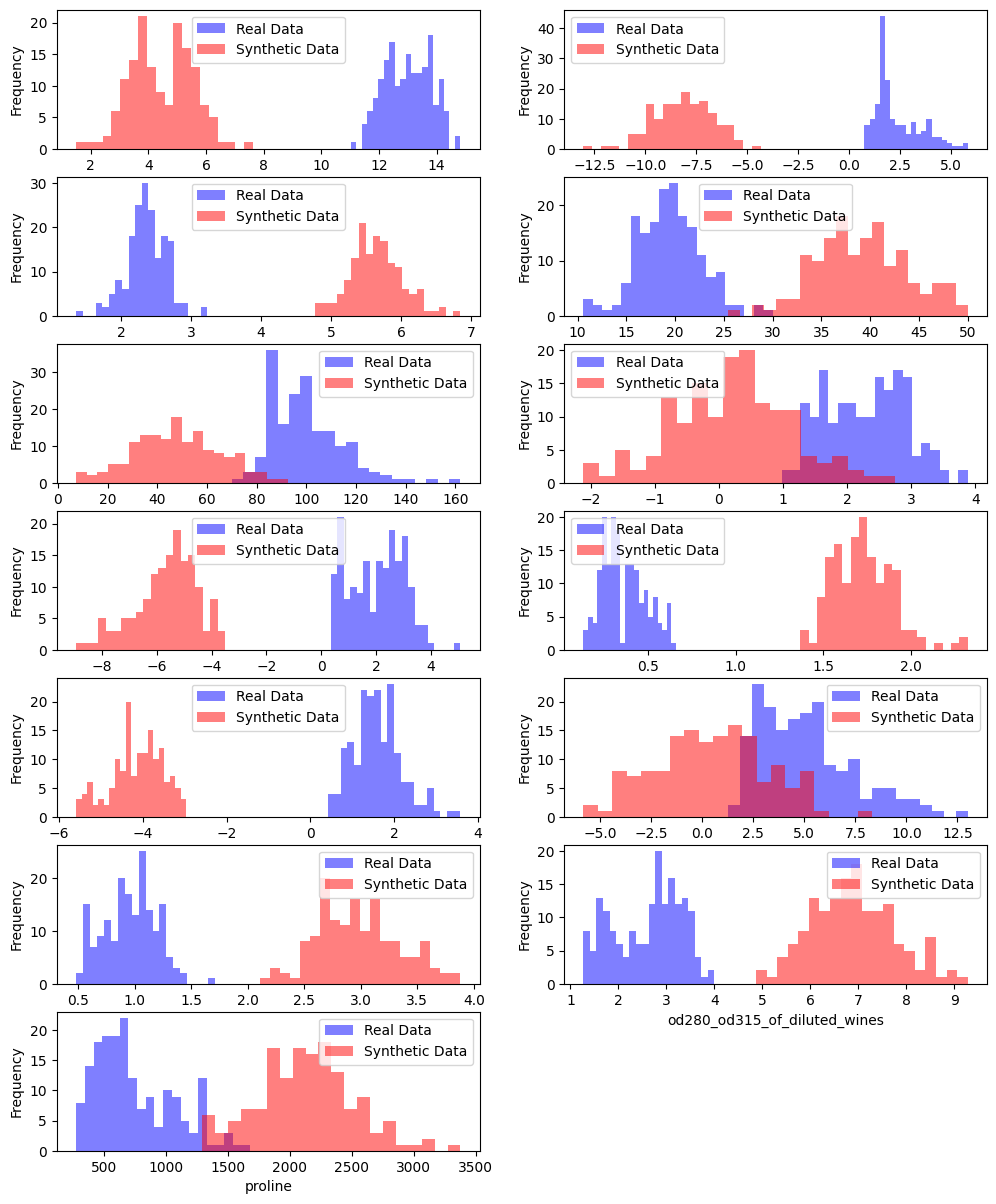

In [32]:
real_data = wine_df.iloc[: , 1:]

# Comparar los datos por varibales distribuidas
plt.figure(figsize=(12, 30))

# Iterar por cada columna apra graficar las distribuciones
for i in range(13):  # Son 13 features que tiene el dataset
    plt.subplot(14, 2, i+1)

    # Graficar histograma para datos reales
    plt.hist(real_data.values[:, i], bins=20, color='blue', alpha=0.5, label='Real Data')

    # Graficar histograma para synthetic data
    plt.hist(synthetic_data.values[:, i], bins=20, color='red', alpha=0.5, label='Synthetic Data')

    # Set labels and legend
    plt.xlabel(real_data.columns[i])
    plt.ylabel('Frequency')
    plt.legend()

plt.show()